**Multi-class text classification with Convolutional Neural Networks (CNN)**

In [26]:
# import libraries
import pandas as pd
import numpy as np

import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from tensorflow import keras
from keras import backend as K, utils
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Activation, Dropout, GlobalMaxPool1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.utils import plot_model
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from keras.backend import clear_session

import matplotlib.pyplot as plt
%matplotlib inline

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [27]:
# load a clean dataset
def load_data(file_path, header=0, squeeze=False):
  return pd.read_csv(file_path, header=header, squeeze=squeeze)


# fit a tokenizer
def create_tokenizer(text):
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(text)
	return tokenizer


# calculate the maximum document length
def max_length(text):
	return max([len(s.split()) for s in text])


# encode a list of textual lines
def encode_text(tokenizer, text, length):
	# integer encode
	encoded = tokenizer.texts_to_sequences(text)
	# pad encoded sequences
	padded = pad_sequences(encoded, maxlen=length, padding='post')
	return padded


# fit a one-hot encoder
def create_onehot_encoder(data, columns=['transaction_type', 'transaction_account_type']):
  onehot_encoder = OneHotEncoder()
  transformer = ColumnTransformer([('onehot_encoder',
                                    onehot_encoder,
                                    columns)])
  transformer.fit(data)
  return transformer


# encode categorical columns
def encode_categories(encoder, data):
  return encoder.transform(data)


# encode output data (labels)
def encode_labels(train_y, test_y):
  encoder = LabelEncoder()
  encoder.fit(train_y)
  train_y = encoder.transform(train_y)
  test_y = encoder.transform(test_y)
  num_classes = np.max(train_y) + 1
  train_y = utils.to_categorical(train_y, num_classes)
  test_y = utils.to_categorical(test_y, num_classes)
  classes = list(encoder.classes_)
  return train_y, test_y, classes


# calculate recall metric
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall


# calculate precision metric
def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision


# calculate f1-score metric
def f1_m(y_true, y_pred):
  precision = precision_m(y_true, y_pred)
  recall = recall_m(y_true, y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))


# plot metric history 
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()


# predict outputs on test data
def predict(model, inputs, classes):
  return pd.DataFrame(model.predict(inputs), columns=classes)
  

# insert predicted class and confidence for each transaction
# make evidence of possible errors with new column
def get_results(df1, df2):
  df2['transaction_class'] = ""
  df2['confidence'] = np.nan
  # Class with maximum probability is predicted class
  # This probability represents confidence
  for index, row in df1.iterrows():
      df2.loc[index, 'transaction_class'] = row.idxmax()
      df2.loc[index, 'confidence'] = row.max()
      if (row.idxmax() in ['payment', 'transfer', 'cash-withdrawal', 'bank-fee'] and df2.loc[index, 'transaction_type'] == 'credit') or \
          (row.idxmax() in ['interest', 'refund', 'transfer'] and df2.loc[index, 'transaction_type'] == 'debit'): 
          df2.loc[index, 'error'] = 0
      else:
          df2.loc[index, 'error'] = 1
  return df2


# separate textual data and categorical columns
def separate_text_and_categories(data, text, categories):
  text_column = data[text]
  categories_df = data[categories]
  return text_column, categories_df


# merge textual data and categorical columns
def combine_text_and_categories(data, text, categories):
  i = 0
  while i < len(categories):
    data[text] = data[text] + " " + data[categories[i]] 
    i += 1
  return data[text]


**CNN (separated inputs)**

In [3]:
# load training dataset
X_train = load_data('drive/MyDrive/Colab Notebooks/basiq/X_train.csv')
y_train = load_data('drive/MyDrive/Colab Notebooks/basiq/y_train.csv', squeeze=True)

# load validation dataset
X_test = load_data('drive/MyDrive/Colab Notebooks/basiq/X_test.csv')
y_test = load_data('drive/MyDrive/Colab Notebooks/basiq/y_test.csv', squeeze=True)

# load test dataset
scorecard_df = load_data('drive/MyDrive/Colab Notebooks/basiq/scorecard_cleaned.csv')

In [4]:
# get text and categorical columns separated
text_train, categories_train = separate_text_and_categories(X_train, 'description_processed', ['transaction_type', 'transaction_account_type'])
text_test, categories_test = separate_text_and_categories(X_test, 'description_processed', ['transaction_type', 'transaction_account_type'])
text_scorecard, categories_scorecard = separate_text_and_categories(scorecard_df, 'description_processed', ['transaction_type', 'transaction_account_type'])

# make sure all text is string
text_train = text_train.astype(str)
text_test = text_test.astype(str)

# create tokenizer
tokenizer = create_tokenizer(text_train)

# calculate max document length
length = max_length(text_train)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode textual data
text_train = encode_text(tokenizer, text_train, length)
text_test = encode_text(tokenizer, text_test, length)
text_scorecard = encode_text(tokenizer, scorecard_df['description_processed'].astype(str), length)
print(f'Training text size: {text_train.shape}')
print(f'Validation text size: {text_test.shape}')
print(f'Testing text size: {text_scorecard.shape}')

# create onehot encoder
encoder = create_onehot_encoder(categories_train)

# encode categorical data
categories_train = encode_categories(encoder, categories_train)
categories_test = encode_categories(encoder, categories_test)
categories_scorecard = encode_categories(encoder, categories_scorecard)

# encode labels
y_train, y_test, classes = encode_labels(y_train, y_test)

Max document length: 20
Vocabulary size: 18326
Training text size: (80000, 20)
Validation text size: (20000, 20)
Testing text size: (467, 20)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text_input (InputLayer)         [(None, 20)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 20, 50)       916300      text_input[0][0]                 
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 17, 32)       6432        embedding[0][0]                  
__________________________________________________________________________________________________
dropout (Dropout)               (None, 17, 32)       0           conv1d[0][0]                     
______________________________________________________________________________________________

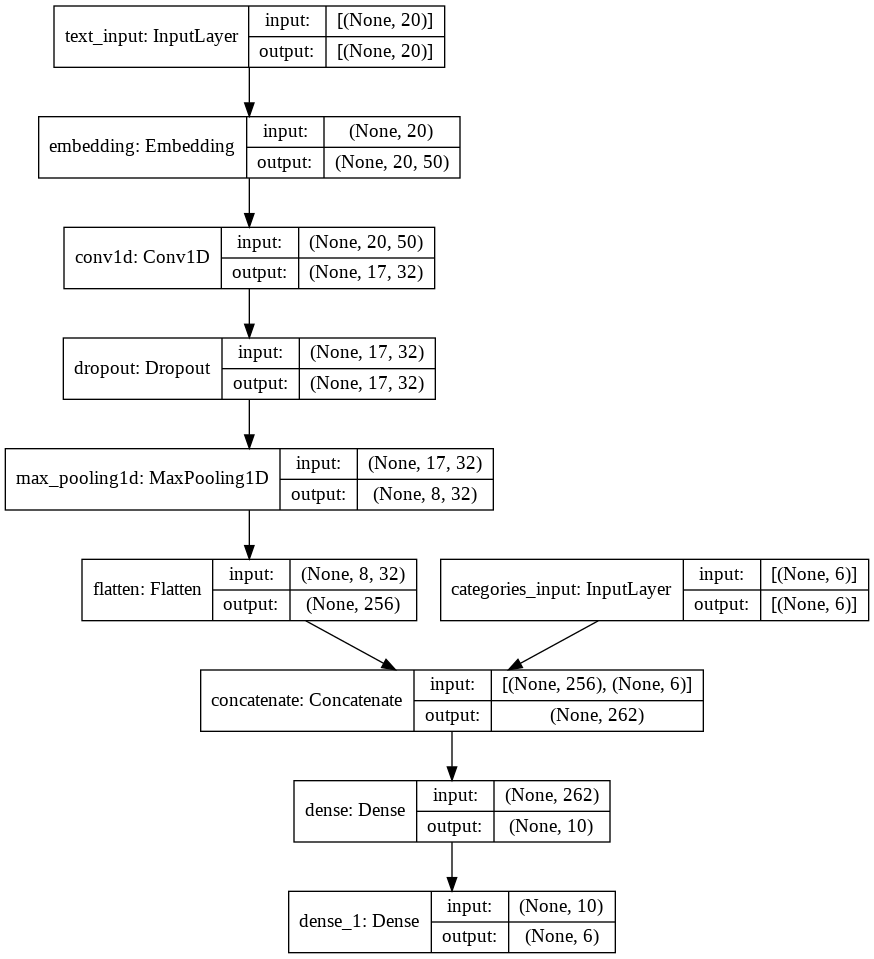

In [5]:
# create model

embedding_size = 50

text_input = Input(shape=(length,), name='text_input')
categories_input = Input(shape=(categories_train.shape[1],), name='categories_input')
emb = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=text_train.shape[1])(text_input)
conv1 = Conv1D(filters=32, kernel_size=4, activation='relu')(emb)
drop1 = Dropout(0.5)(conv1)
pool1 = MaxPooling1D(pool_size=2)(drop1)
text_output = Flatten()(pool1)
merged = concatenate([text_output, categories_input])
dense1 = Dense(10, activation='relu')(merged)
outputs = Dense(y_train.shape[1], activation='softmax')(dense1)

model_cnn_1 = Model(inputs=[text_input , categories_input], outputs=outputs)
model_cnn_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=f1_m)

# summarize
print(model_cnn_1.summary())
plot_model(model_cnn_1, show_shapes=True, show_layer_names=True, to_file='drive/MyDrive/Colab Notebooks/basiq/CNN_1.png')

In [6]:
# train model
batch_size = 100
epochs = 10

history_5 = model_cnn_1.fit([text_train, categories_train], y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=([text_test, categories_test], y_test))

Epoch 1/10
800/800 [==============================] - 11s 10ms/step - loss: 0.6152 - f1_m: 0.6712 - val_loss: 0.0288 - val_f1_m: 0.9957
Epoch 2/10
800/800 [==============================] - 8s 9ms/step - loss: 0.0274 - f1_m: 0.9941 - val_loss: 0.0179 - val_f1_m: 0.9965
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.0158 - f1_m: 0.9964 - val_loss: 0.0135 - val_f1_m: 0.9968
Epoch 4/10
800/800 [==============================] - 7s 9ms/step - loss: 0.0108 - f1_m: 0.9976 - val_loss: 0.0152 - val_f1_m: 0.9968
Epoch 5/10
800/800 [==============================] - 8s 9ms/step - loss: 0.0078 - f1_m: 0.9980 - val_loss: 0.0139 - val_f1_m: 0.9965
Epoch 6/10
800/800 [==============================] - 8s 9ms/step - loss: 0.0064 - f1_m: 0.9982 - val_loss: 0.0127 - val_f1_m: 0.9973
Epoch 7/10
800/800 [==============================] - 8s 9ms/step - loss: 0.0049 - f1_m: 0.9988 - val_loss: 0.0136 - val_f1_m: 0.9967
Epoch 8/10
800/800 [==============================] - 8s 9ms

In [7]:
# evaluate model
loss, f1_m = model_cnn_1.evaluate([text_train, categories_train] , y_train, verbose=False)
print("Training F1 score: {:.4f}".format(f1_m))
loss, f1_m = model_cnn_1.evaluate([text_test, categories_test], y_test, verbose=False)
print("Testing F1 score:  {:.4f}".format(f1_m))

Training F1 score: 0.9994
Testing F1 score:  0.9972


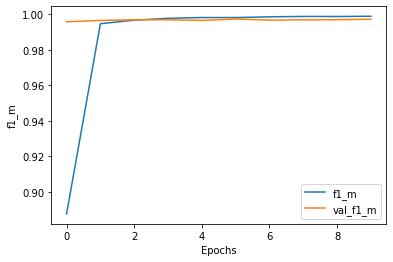

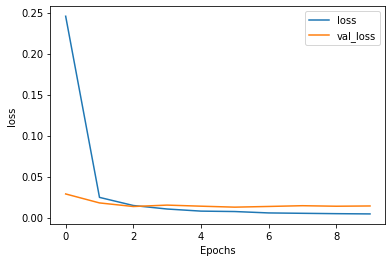

In [8]:
# plot metrics history
plot_graphs(history_5, "f1_m")
plot_graphs(history_5, "loss")

In [9]:
# save model
model_cnn_1.save('drive/MyDrive/Colab Notebooks/basiq/cnn_1.h5')

In [11]:
# make predictions on test set
results_5 = predict(model_cnn_1, [text_scorecard, categories_scorecard], classes)

In [12]:
# get results
results_CNN_1 = scorecard_df.copy()
results_CNN_1 = get_results(results_5, results_CNN_1)
results_CNN_1.head()

,transaction_description,transaction_amount,transaction_account_type,description_processed,transaction_type,transaction_class,confidence,error
0,0011393060001 Transfer to Macquarie Bank - Rec...,-342.52,transaction,transfer macquarie bank receipt,credit,transfer,0.998944,0.0
1,0318352 Transfer to Jimboomba Gymnastics Club ...,-157.50,transaction,transfer jimboomba gymnastics club receipt,credit,transfer,0.999859,0.0
2,0REGENTVILLE PS 2951 Visa Purchase - Receipt 1...,-49.00,transaction,regentville visa purchase receipt regentville ...,credit,payment,0.998721,0.0
3,0TUGGERAWONG PS 4097 Visa Purchase - Receipt 1...,-20.00,transaction,tuggerawong visa purchase receipt tuggerawong ...,credit,payment,0.998721,0.0
4,1001026 Transfer to Blink Property - Receipt 6...,-710.00,transaction,transfer blink property receipt,credit,transfer,0.999996,0.0


In [13]:
# how many sure missclassified transactions
print(results_CNN_1['error'].sum().astype(int))

1


In [14]:
# class distribution
results_CNN_1['transaction_class'].value_counts()

payment            393
transfer            47
cash-withdrawal     18
bank-fee             7
refund               2
Name: transaction_class, dtype: int64

In [15]:
# sort prediction by lowest confidence
results_CNN_1.sort_values(by="confidence")

,transaction_description,transaction_amount,transaction_account_type,description_processed,transaction_type,transaction_class,confidence,error
46,AP#12243218 TO KIWIBANK PERSONAL MASTERCARD,-1000.0,transaction,kiwibank personal master,credit,bank-fee,0.458655,0.0
47,AP#12409235 TO VODAFONE (MOBILE),-50.0,transaction,vodafone mobile,credit,transfer,0.461079,0.0
414,TOPLINE HAIRDRESSERS 163617238424,-15.0,transaction,topline hairdresser,credit,payment,0.501800,0.0
42,Andy AMEX Travel Insurance premium BPAY Bill P...,-746.0,transaction,andy amex travel insurance premium bpay bill p...,credit,payment,0.514568,0.0
446,"Withdrawal - Non BBL ATM, DURAL CALTEX DURAL",-100.0,transaction,withdrawal non bbl atm dural caltex dural,credit,bank-fee,0.684841,0.0
...,...,...,...,...,...,...,...,...
80,Bbq Internal Transfer - Receipt 238778 Orange ...,-20.0,transaction,bbq internal transfer receipt orange everyday,credit,transfer,1.000000,0.0
460,Zali Felicity presents Internal Transfer - Rec...,-47.4,transaction,zali felicity present internal transfer receip...,credit,transfer,1.000000,0.0
255,iou Internal Transfer - Receipt 540579 Savings...,100.0,savings,iou internal transfer receipt saving maximiser,debit,transfer,1.000000,0.0
114,Booze Internal Transfer - Receipt 602433 Orang...,-200.0,transaction,booze internal transfer receipt orange everyday,credit,transfer,1.000000,0.0


In [40]:
# save results
results_CNN_1.to_csv("drive/MyDrive/Colab Notebooks/basiq/results_CNN_1.csv", index=False)

In [16]:
# clear session before start to train model again
clear_session()

**CNN (merged inputs)**


In [28]:
# load training dataset
X_train = load_data('drive/MyDrive/Colab Notebooks/basiq/X_train.csv')
y_train = load_data('drive/MyDrive/Colab Notebooks/basiq/y_train.csv', squeeze=True)

# load validation dataset
X_test = load_data('drive/MyDrive/Colab Notebooks/basiq/X_test.csv')
y_test = load_data('drive/MyDrive/Colab Notebooks/basiq/y_test.csv', squeeze=True)

# load test dataset
scorecard_df = load_data('drive/MyDrive/Colab Notebooks/basiq/scorecard_cleaned.csv')

In [29]:
# get text and categorical columns together
text_train = combine_text_and_categories(X_train, 'description_processed', ['transaction_type', 'transaction_account_type'])
text_test = combine_text_and_categories(X_test, 'description_processed', ['transaction_type', 'transaction_account_type'])
text_scorecard = combine_text_and_categories(scorecard_df, 'description_processed', ['transaction_type', 'transaction_account_type'])

# make sure all text is string
text_train = text_train.astype(str)
text_test = text_test.astype(str)

# create tokenizer
tokenizer = create_tokenizer(text_train)

# calculate max document length
length = max_length(text_train)

# calculate vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Max document length: %d' % length)
print('Vocabulary size: %d' % vocab_size)

# encode textual data
text_train = encode_text(tokenizer, text_train, length)
text_test = encode_text(tokenizer, text_test, length)
text_scorecard = encode_text(tokenizer, scorecard_df['description_processed'].astype(str), length)
print(f'Training text size: {text_train.shape}')
print(f'Validation text size: {text_test.shape}')
print(f'Testing text size: {text_scorecard.shape}')

# encode labels
y_train, y_test, classes = encode_labels(y_train, y_test)

Max document length: 22
Vocabulary size: 18329
Training text size: (80000, 22)
Validation text size: (20000, 22)
Testing text size: (467, 22)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 22, 50)            916450    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 19, 32)            6432      
_________________________________________________________________
dropout_3 (Dropout)          (None, 19, 32)            0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 9, 32)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 288)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                2890      
_________________________________________________________________
dense_7 (Dense)              (None, 6)                

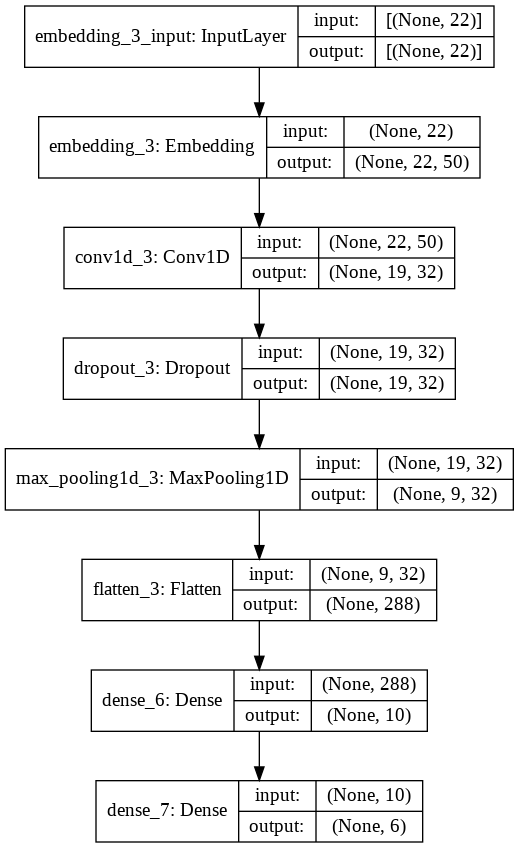

In [30]:
# create model

embedding_size = 50

model_cnn_2 = Sequential()
model_cnn_2.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=length))
model_cnn_2.add(Conv1D(32, 4, activation='relu'))
model_cnn_2.add(Dropout(0.5))
model_cnn_2.add(MaxPooling1D(pool_size=2))
model_cnn_2.add(Flatten())
model_cnn_2.add(Dense(10, activation='relu'))
model_cnn_2.add(Dense(y_train.shape[1], activation='softmax'))

model_cnn_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=f1_m)

# summarize
print(model_cnn_2.summary())
plot_model(model_cnn_2, show_shapes=True, show_layer_names=True, to_file='drive/MyDrive/Colab Notebooks/basiq/CNN_2.png')

In [31]:
# train model
batch_size = 100
epochs = 10

history_6 = model_cnn_2.fit(text_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(text_test, y_test))

Epoch 1/10
800/800 [==============================] - 8s 10ms/step - loss: 0.7128 - f1_m: 0.6142 - val_loss: 0.0244 - val_f1_m: 0.9957
Epoch 2/10
800/800 [==============================] - 7s 9ms/step - loss: 0.0238 - f1_m: 0.9945 - val_loss: 0.0144 - val_f1_m: 0.9971
Epoch 3/10
800/800 [==============================] - 7s 9ms/step - loss: 0.0116 - f1_m: 0.9971 - val_loss: 0.0121 - val_f1_m: 0.9974
Epoch 4/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0097 - f1_m: 0.9977 - val_loss: 0.0116 - val_f1_m: 0.9973
Epoch 5/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0073 - f1_m: 0.9981 - val_loss: 0.0119 - val_f1_m: 0.9973
Epoch 6/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0060 - f1_m: 0.9984 - val_loss: 0.0118 - val_f1_m: 0.9973
Epoch 7/10
800/800 [==============================] - 8s 10ms/step - loss: 0.0050 - f1_m: 0.9987 - val_loss: 0.0118 - val_f1_m: 0.9973
Epoch 8/10
800/800 [==============================] - 8s 

In [32]:
# evaluate model
loss, f1_m = model_cnn_2.evaluate(text_train, y_train, verbose=False)
print("Training F1 score: {:.4f}".format(f1_m))
loss, f1_m = model_cnn_2.evaluate(text_test, y_test, verbose=False)
print("Testing F1 score:  {:.4f}".format(f1_m))

Training F1 score: 0.9994
Testing F1 score:  0.9976


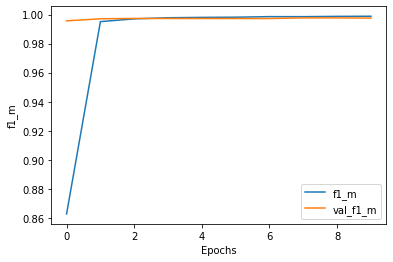

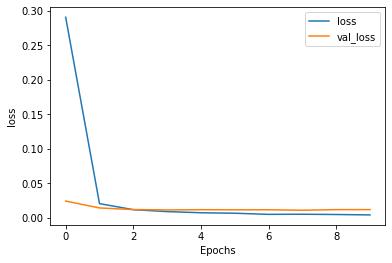

In [33]:
# plot metrics history
plot_graphs(history_6, "f1_m")
plot_graphs(history_6, "loss")

In [34]:
# save model
model_cnn_2.save('drive/MyDrive/Colab Notebooks/basiq/cnn_2.h5')

In [35]:
# make predictions on test set
results_6 = predict(model_cnn_2, text_scorecard, classes)

In [36]:
# get results
results_CNN_2 = scorecard_df.copy()
results_CNN_2 = get_results(results_6, results_CNN_2)
results_CNN_2.head()

,transaction_description,transaction_amount,transaction_account_type,description_processed,transaction_type,transaction_class,confidence,error
0,0011393060001 Transfer to Macquarie Bank - Rec...,-342.52,transaction,transfer macquarie bank receipt credit transac...,credit,transfer,0.999179,0.0
1,0318352 Transfer to Jimboomba Gymnastics Club ...,-157.50,transaction,transfer jimboomba gymnastics club receipt cre...,credit,transfer,0.999775,0.0
2,0REGENTVILLE PS 2951 Visa Purchase - Receipt 1...,-49.00,transaction,regentville visa purchase receipt regentville ...,credit,payment,0.997335,0.0
3,0TUGGERAWONG PS 4097 Visa Purchase - Receipt 1...,-20.00,transaction,tuggerawong visa purchase receipt tuggerawong ...,credit,payment,0.997335,0.0
4,1001026 Transfer to Blink Property - Receipt 6...,-710.00,transaction,transfer blink property receipt credit transac...,credit,transfer,0.999998,0.0


In [37]:
# how many sure missclassified transactions
print(results_CNN_2['error'].sum().astype(int))

1


In [38]:
# class distribution
results_CNN_2['transaction_class'].value_counts()

payment            392
transfer            49
cash-withdrawal     21
bank-fee             3
refund               2
Name: transaction_class, dtype: int64

In [39]:
# sort prediction by lowest confidence
results_CNN_2.sort_values(by="confidence")

,transaction_description,transaction_amount,transaction_account_type,description_processed,transaction_type,transaction_class,confidence,error
414,TOPLINE HAIRDRESSERS 163617238424,-15.00,transaction,topline hairdresser credit transaction,credit,cash-withdrawal,0.359855,0.0
107,BOLT.EU /O/2001311926-Eveleigh NSW-Hold for AT...,-150.00,transaction,bolt eveleigh nswhold atm debit offline transa...,credit,transfer,0.532962,0.0
105,BLS*ONLYDOMAINS.COM LONDON GBR Card xx7977 AUD...,-10.95,transaction,bls london gbr aud value date date credit tran...,credit,cash-withdrawal,0.534420,0.0
58,AUSPOST ONLINE RETURNS Visa Purchase - Receipt...,-8.95,transaction,auspost online return visa purchase receipt me...,credit,refund,0.583805,1.0
21,Acquisitions Lambton ************ 0563 33464,-84.98,other,acquisition lambton credit other,credit,payment,0.596611,0.0
...,...,...,...,...,...,...,...,...
114,Booze Internal Transfer - Receipt 602433 Orang...,-200.00,transaction,booze internal transfer receipt orange everyda...,credit,transfer,1.000000,0.0
34,ALPINE ANIMAL DOCTORS PO REPUNKAH03 EFTPOS Pur...,-390.61,transaction,alpine animal doctor repunkah eftpos purchase ...,credit,payment,1.000000,0.0
411,TFNSW RAIL MASCOT EFTPOS Purchase - Receipt 11...,-20.00,transaction,tfnsw rail mascot eftpos purchase receipt date...,credit,payment,1.000000,0.0
64,B INDULGED HAIR AND EASTERN HEI EFTPOS Purchas...,-120.00,savings,indulged hair eastern hei eftpos purchase rece...,credit,payment,1.000000,0.0


Hyperparameters tuning (needs time)

In [9]:
def create_model(num_filters, kernel_size, vocab_size, embedding_size, maxlen):
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_size, input_length=maxlen))
  model.add(Conv1D(num_filters, kernel_size, activation='relu'))
  model.add(MaxPooling1D())
  model.add(Flatten())
  model.add(Dense(10, activation='relu'))
  model.add(Dense(6, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m])
  return model

In [ ]:
epochs = 5
# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_size=[10, 50, 100],
                  maxlen=[length])
model_cnn_2 = KerasClassifier(build_fn=create_model,
                              epochs=epochs, batch_size=10,
                              verbose=False)
grid = RandomizedSearchCV(estimator=model_cnn_2, param_distributions=param_grid,
                          cv=5, verbose=1, n_iter=5)
grid_result = grid.fit(text_train, y_train)

In [ ]:
# Evaluate testing set
test_f1 = grid.score(text_test, y_test)